### Екип
Рая Симеонова - 62557  
Надя Катевска - 250 

### Проект
   
Тип на проекта: А  
Название на проекта: San Francisco Crime Classification

#### Кратко описание на данните

В dataset-а се срещат следните характеристики на данните:

- Dates - дата и час на престъплението
- Category - категория на престъплението (само в train.csv). Таргет променливата, която трябва да се предвиди.
- Descript - подробно описание на престъплението (само в train.csv)
- DayOfWeek - денят в седмицата
- PdDistrict - името на районното полицейско управление
- Resolution - как престъплението е разрешено (само в train.csv)
- Address - приблизителния адрес на престъплението 
- X - географска дължина
- Y - географска щирина

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('sf-crime/train.csv')

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB
None


Данните изглеждат по-този начин. Dates колоната може да се парсне и да се извлекат данните за година, месец, ден поотделно.

In [4]:
data.head(3)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414


In [5]:
data['Dates'] = pd.to_datetime(data['Dates'], format='%Y-%m-%d %H:%M:%S')
data['Year'] = data['Dates'].dt.year
data['Month'] = data['Dates'].dt.month
data['Day'] = data['Dates'].dt.day
data['Hour'] = data['Dates'].dt.hour

In [6]:
data.head(2)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,Day,Hour
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23


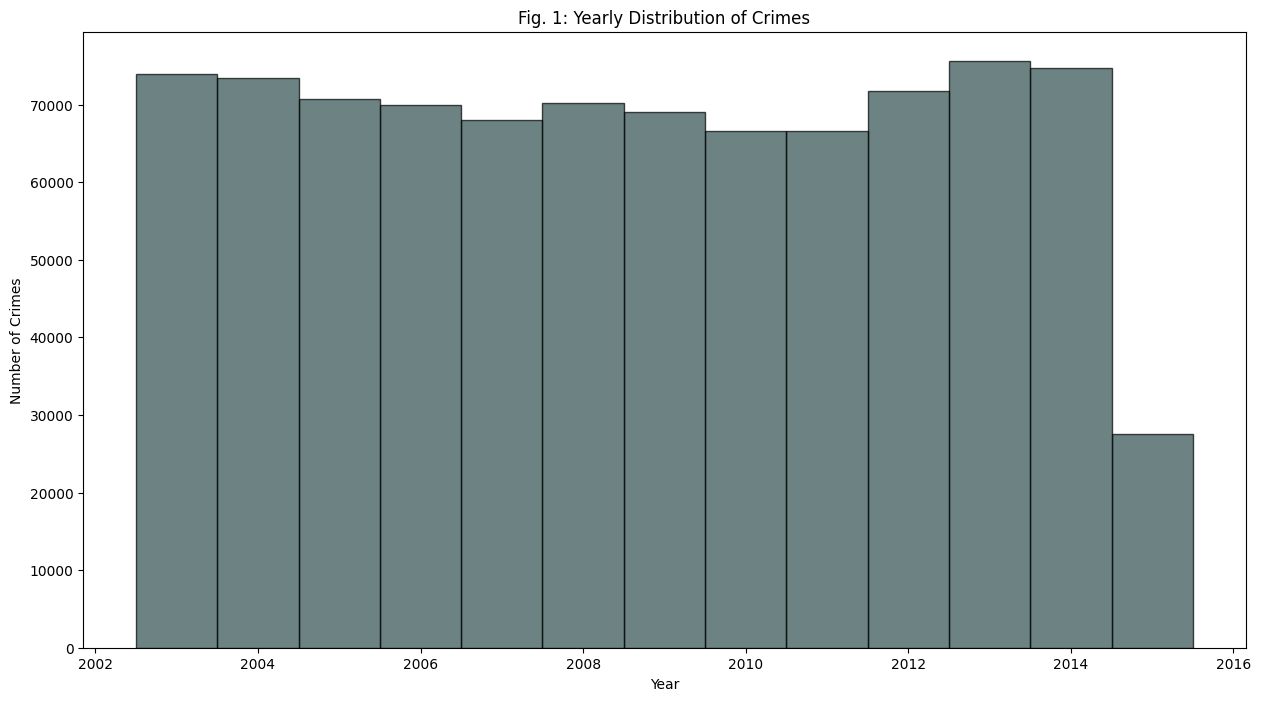

In [7]:
plt.figure(figsize=(15, 8))
years = data['Year'].unique()
for year in years:
    plt.hist(data[data['Year'] == year]['Year'], bins=1, color='darkslategray', edgecolor='black', label=str(year), alpha=0.7)

plt.title('Fig. 1: Yearly Distribution of Crimes')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.show()

На Fig. 1 се вижда, че разпределението на престъпленията по години (между 2003 и 2015) е равномерно. Вижда се, че през 2015 разпределението на престъпленията е на половина, но и в dataset-а рекордите за престъпления за тази година са само до средата Й.

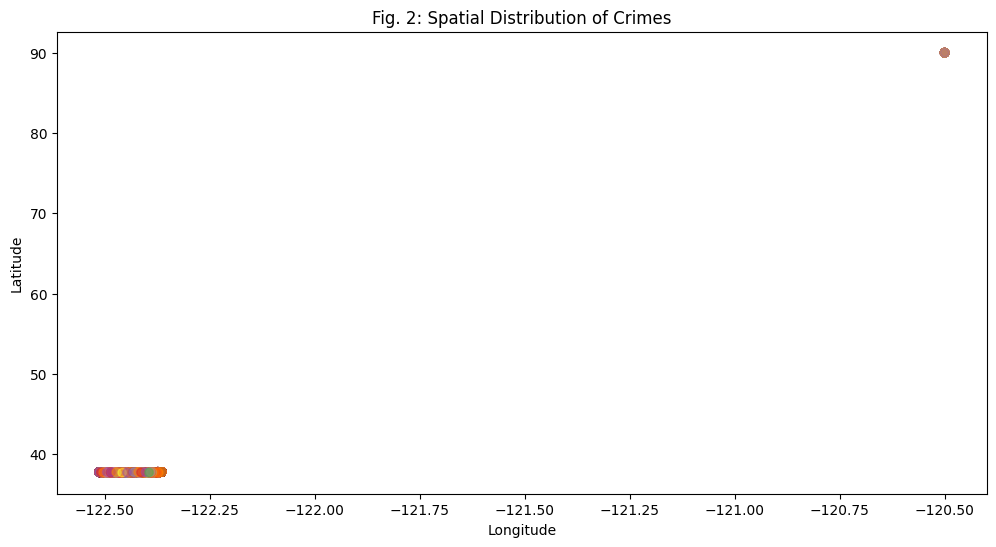

In [8]:
plt.figure(figsize=(12, 6))
plt.scatter(data['X'], data['Y'], c=data['Category'].astype('category').cat.codes, cmap='Set1', alpha=0.5)
plt.title('Fig. 2: Spatial Distribution of Crimes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

На Fig. 2 се вижда, че повечето престъпления са в един участък, освен няколко outlier-а, които ще трябва да се вземат предвид при обработката на данни.

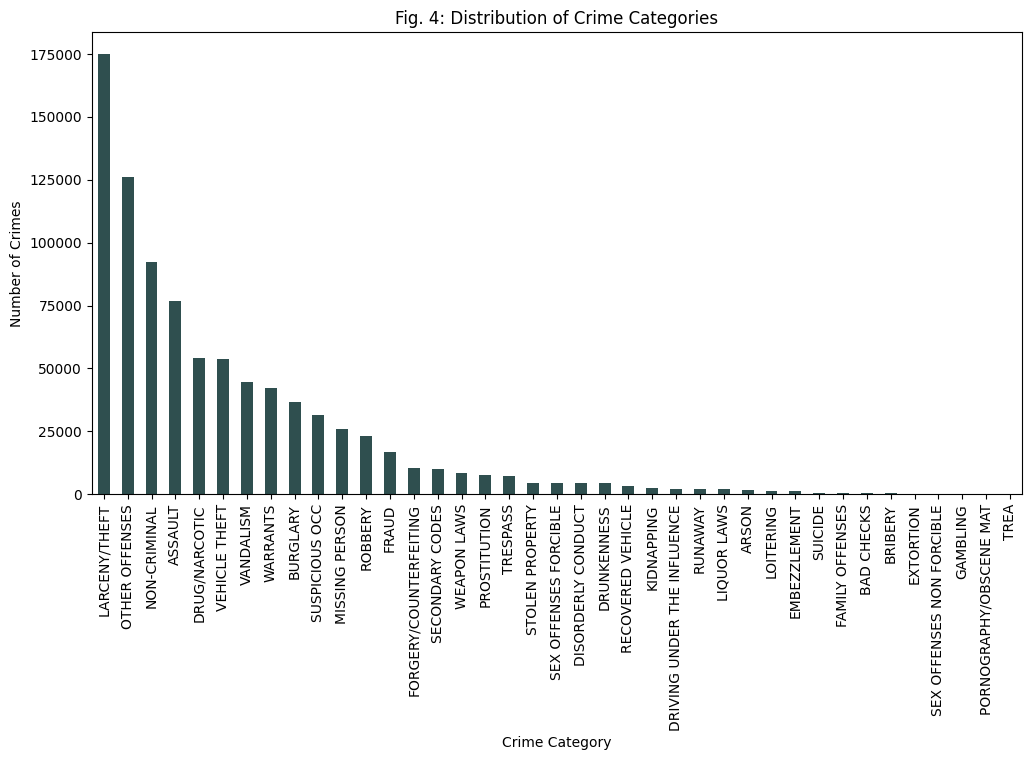

In [9]:
plt.figure(figsize=(12, 6))
data['Category'].value_counts().plot(kind='bar', color='darkslategray')
plt.title('Fig. 4: Distribution of Crime Categories')
plt.xlabel('Crime Category')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=90)
plt.show()

На Fig. 4 се вижда, че разпределението на категориите (таргет променливата) е доста несъразмерно - първите няколко са най-често срещаните, в сравнение с които последните изглежда са незначителни.

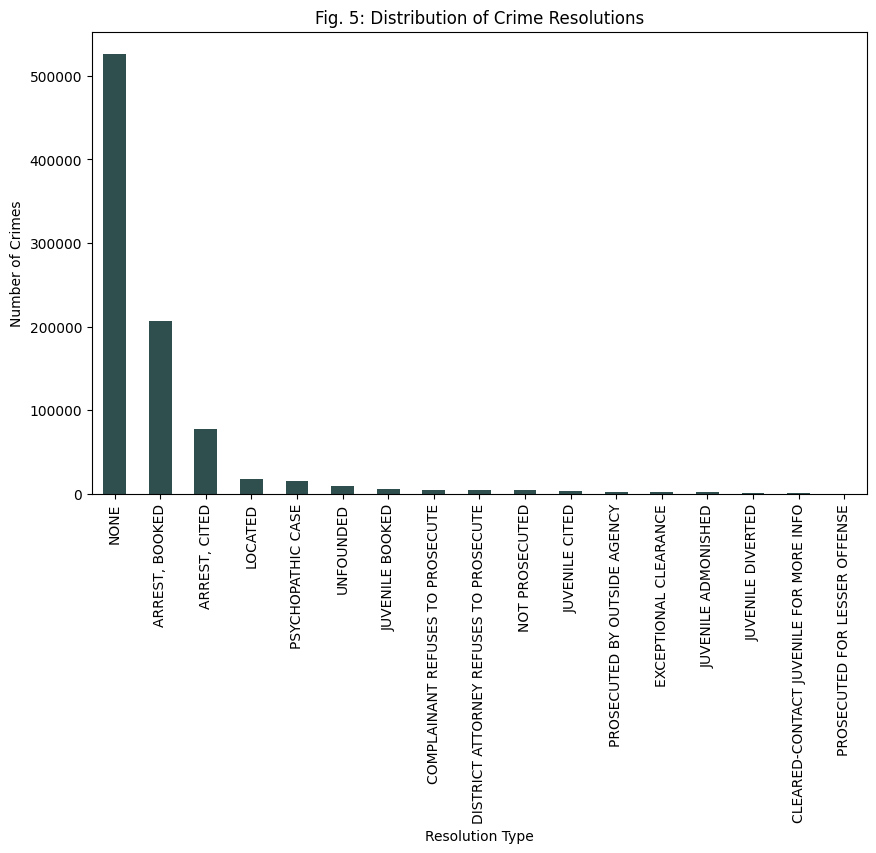

In [10]:
plt.figure(figsize=(10, 6))
data['Resolution'].value_counts().plot(kind='bar', color='darkslategray')
plt.title('Fig. 5: Distribution of Crime Resolutions')
plt.xlabel('Resolution Type')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=90)
plt.show()

На Fig. 5 се вижда, че повечете преестъпления остават неразрешени. Може да престъплението да е силно зависимо от разрешимостта.

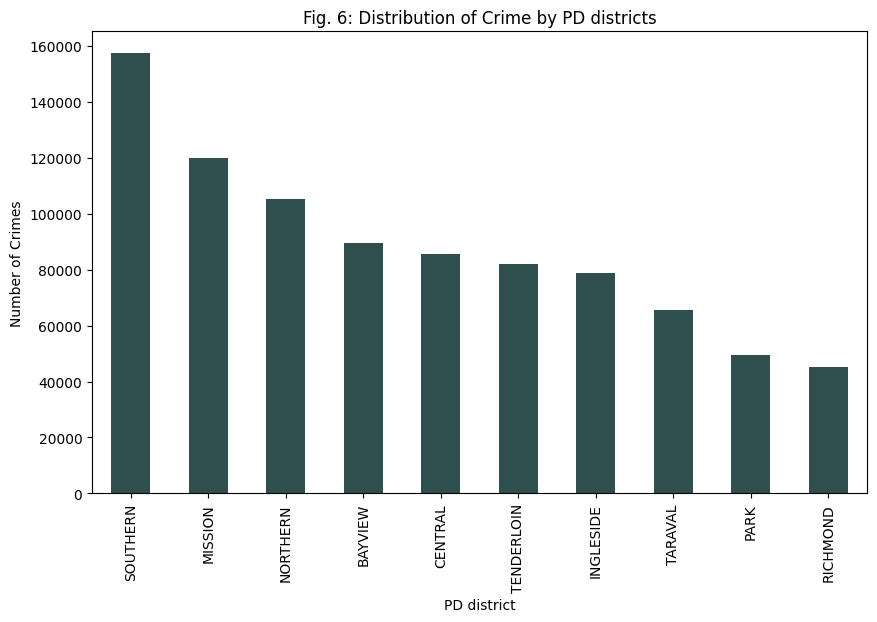

In [11]:
plt.figure(figsize=(10, 6))
data['PdDistrict'].value_counts().plot(kind='bar', color='darkslategray')
plt.title('Fig. 6: Distribution of Crime by PD districts')
plt.xlabel('PD district')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=90)
plt.show()

На Fig. 6 се забелязва как престъпленията нямаляват спрямо района на полицейските участъци.

#### Кратко описание на алгоритмите, които ще използвате

- Логистична регресия  
Сравнително прост алгоритъм, който ще използвам като стартиращ базов модел, за да се определи дали има линейна зависимост между характеристиките на dataset-а.
  
- kNN  
kNN е прост алгоритъм за пространствен анализ. Той класифицира точките от данни въз основа на класа на мнозинството от техните най-близки съседи. Предвид географския характер на данните за престъпността (дължина, ширина, адрес, участък), kNN може да бъде ефективен за прогнозиране на категории престъпления въз основа на характеристиките на близките инциденти.
   
- Random Forest  
Random Forest е енсенбъл метод за обучение. Той се справя се с нелинейността и е по-малко склонен към overfitting от decision tree алгоритъм. Също така, имайки предвид, че таргет променливата е доста небалансирана в обучаващото множество, този алгоритъм може би ще се справи по-добре при предсказването.

#### Библиотеки и технологии

- Python
- Jupyter
- pandas
- scikit-learn
- matplotlib
- seaborn